# Part 3 Feature Selection 


### Goal: 
Use 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of randomly selecteed features to train the neural network and test on it respectively. You build 9 systems. Plot a graph where the x-axis indicates the percentage of features you used to train a system, and the y-axis indicate the accuracy on the test set of each system 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import h5py
import numpy as np
import matplotlib.pyplot as plt 

import sklearn 
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras import models 
from keras.layers import Dense
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import math

import tensorflow as tf

Using TensorFlow backend.


In [2]:
def dataCollection(): 
    print("Data Collection")
    wine = sklearn.datasets.load_wine()
    
    df = pd.DataFrame(wine.data)
    df.columns = wine.feature_names
    df["class"] = wine.target
    
    labels = df.loc[:,["class"]] 
    features = df.drop(["class"],axis=1)
    
    return features, labels

Discussion:     
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While there are various types of feature selection and dimensionalty reduction, I chose to use a type of feature selection called recursive feature elimination (RFE) which works by recursively removing attributes and building a model on those attributes that remain. I chose to use a random forest classifier to identify attributes contribute the most to predicting the labels.      
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The number of features to select by the RFE is determined by multiplying the percentage to the total number of features in the dataset(13)

In [3]:
def rfe(percentage, features, labels): 
    '''
    Applies recursive feature elimination to find percentage of features to use 
    Returns selected features 
    '''
    print("RFE")
    rfc = RandomForestClassifier(random_state = 101)
    
    # Number of features to select is the percentage given * total features - rounded 
    rfe = RFE(rfc, n_features_to_select = math.floor(percentage*13))
    fit = rfe.fit(features, labels)
    
    print("Number of Features", fit.n_features_)
    print("Ranking of Features", fit.ranking_)
    print("Selected Features", fit.support_)
    
    # selected features from original dataset  
    features = features.loc[:, list(fit.support_)] 
    
    return features 

In [4]:
def dataPrep(features, labels):
    '''
    Prepares features and labels into its respective sets 
    '''
    print("dataPrep")
    xtrain, xtest, ytrain, ytest = train_test_split(features, labels)
    
    #convert labels to categorical 
    ytrain = to_categorical(ytrain, 3)
    ytest = to_categorical(ytest,3)
    
    # Scale data 
    scale = MinMaxScaler(feature_range=(0,1))
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.fit_transform(xtest)
    return xtrain, xtest, ytrain, ytest 

In [5]:
def trainModel(xtrain, ytrain):
    '''
    Builds and runs training model 
    '''
    print("Training the Model")
    
    model = Sequential()
    model.add(Dense(10, input_dim=xtrain.shape[1],activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    # Save weights 
    checkpoint = ModelCheckpoint("model_part3.hdf5", monitor="loss", verbose=1, save_best_only = True, mode="auto", period=1)
    
    # Apply early stopping to prevent overfitting 
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',restore_best_weights=True)
    
    # Run Model 
    history = model.fit(xtrain, ytrain, batch_size=50, epochs=2000, verbose =0, validation_split=0.3, callbacks=[checkpoint,monitor])
    

In [6]:
def testModel(xtest, ytest): 
    '''
    Builds and runs testing model 
    '''
    print("Testing the model")
    
    evalModel = Sequential()
    evalModel.add(Dense(10, input_dim=xtest.shape[1],activation='relu'))
    evalModel.add(Dense(8, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(4, activation='relu'))
    evalModel.add(Dense(3, activation='softmax'))


    evalModel.load_weights('model_part3.hdf5')
    evalModel.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    lossAndAcc = evalModel.evaluate(xtest, ytest)

    return lossAndAcc[1]

In [7]:
def main(percent_features, accuracy): 
    '''
    Driver for program 
    '''
    features, labels = dataCollection()
   
    for i in range(len(percent_features)): 
        print("====================================================")
        print("Percent Features ", percent_features[i])
 
        # Call Recursive Feature Elimation given percent features 
        new_features = rfe(percent_features[i], features, labels)
        
        # Split features and labels 
        xtrain, xtest, ytrain, ytest = dataPrep(new_features, labels)
        
        # Train Model 
        trainModel(xtrain, ytrain)
        
        # Test Model
        curr_acc = testModel(xtest, ytest)
        
        # Add accuracy to our list 
        accuracy.append(curr_acc)
        
        print("====================================================\n")

    
    return accuracy


In [8]:
percent_features = [0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accuracy = []

acc = main(percent_features, accuracy)

Data Collection
Percent Features  0.2
RFE
Number of Features 2
Ranking of Features [ 4  8 11  9  7  6  1 12 10  1  5  3  2]
Selected Features [False False False False False False  True False False  True False False
 False]
dataPrep
Training the Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Epoch 00001: loss improved from inf to 1.07581, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.07581 to 1.06799, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.06799 to 1.06100, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.06100 to 1.05365, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.05365 to 1.04691, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.04691 to 1.04033, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.04033 to 1.03382, saving model to model_part3.hdf5

Epoch 00008: loss improved fro


Epoch 00093: loss improved from 0.67029 to 0.66877, saving model to model_part3.hdf5

Epoch 00094: loss improved from 0.66877 to 0.66367, saving model to model_part3.hdf5

Epoch 00095: loss did not improve from 0.66367

Epoch 00096: loss improved from 0.66367 to 0.65798, saving model to model_part3.hdf5

Epoch 00097: loss improved from 0.65798 to 0.65549, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.65549 to 0.65155, saving model to model_part3.hdf5

Epoch 00099: loss improved from 0.65155 to 0.64993, saving model to model_part3.hdf5

Epoch 00100: loss improved from 0.64993 to 0.64537, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.64537 to 0.64424, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.64424 to 0.63948, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.63948 to 0.63879, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.63879 to 0.63420, saving model to model_part3.hdf5

Epoch


Epoch 00202: loss improved from 0.40751 to 0.40741, saving model to model_part3.hdf5

Epoch 00203: loss did not improve from 0.40741

Epoch 00204: loss did not improve from 0.40741
Testing the model
45/45 [==============================] - 0s 675us/step

Percent Features  0.3
RFE
Number of Features 3
Ranking of Features [ 3  7 10  8  6  5  1 11  9  1  4  2  1]
Selected Features [False False False False False False  True False False  True False False
  True]
dataPrep
Training the Model

Epoch 00001: loss improved from inf to 1.07191, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.07191 to 1.06169, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.06169 to 1.05529, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.05529 to 1.04852, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.04852 to 1.04330, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.04330 to 1.03777, saving model to model_part3.hd


Epoch 00094: loss improved from 0.60016 to 0.59421, saving model to model_part3.hdf5

Epoch 00095: loss improved from 0.59421 to 0.58853, saving model to model_part3.hdf5

Epoch 00096: loss improved from 0.58853 to 0.58176, saving model to model_part3.hdf5

Epoch 00097: loss improved from 0.58176 to 0.57618, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.57618 to 0.57013, saving model to model_part3.hdf5

Epoch 00099: loss improved from 0.57013 to 0.56360, saving model to model_part3.hdf5

Epoch 00100: loss improved from 0.56360 to 0.55787, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.55787 to 0.55274, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.55274 to 0.54591, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.54591 to 0.54005, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.54005 to 0.53368, saving model to model_part3.hdf5

Epoch 00105: loss improved from 0.53368 to 0.52820, s


Epoch 00016: loss improved from 1.08645 to 1.08551, saving model to model_part3.hdf5

Epoch 00017: loss improved from 1.08551 to 1.08465, saving model to model_part3.hdf5

Epoch 00018: loss improved from 1.08465 to 1.08406, saving model to model_part3.hdf5

Epoch 00019: loss improved from 1.08406 to 1.08287, saving model to model_part3.hdf5

Epoch 00020: loss improved from 1.08287 to 1.08203, saving model to model_part3.hdf5

Epoch 00021: loss improved from 1.08203 to 1.08075, saving model to model_part3.hdf5

Epoch 00022: loss improved from 1.08075 to 1.07985, saving model to model_part3.hdf5

Epoch 00023: loss improved from 1.07985 to 1.07846, saving model to model_part3.hdf5

Epoch 00024: loss improved from 1.07846 to 1.07720, saving model to model_part3.hdf5

Epoch 00025: loss improved from 1.07720 to 1.07603, saving model to model_part3.hdf5

Epoch 00026: loss improved from 1.07603 to 1.07482, saving model to model_part3.hdf5

Epoch 00027: loss improved from 1.07482 to 1.07390, s


Epoch 00113: loss improved from 0.77745 to 0.77617, saving model to model_part3.hdf5

Epoch 00114: loss improved from 0.77617 to 0.77351, saving model to model_part3.hdf5

Epoch 00115: loss improved from 0.77351 to 0.77063, saving model to model_part3.hdf5

Epoch 00116: loss improved from 0.77063 to 0.76849, saving model to model_part3.hdf5

Epoch 00117: loss did not improve from 0.76849

Epoch 00118: loss improved from 0.76849 to 0.76544, saving model to model_part3.hdf5

Epoch 00119: loss improved from 0.76544 to 0.76297, saving model to model_part3.hdf5

Epoch 00120: loss improved from 0.76297 to 0.76128, saving model to model_part3.hdf5

Epoch 00121: loss improved from 0.76128 to 0.75996, saving model to model_part3.hdf5

Epoch 00122: loss improved from 0.75996 to 0.75804, saving model to model_part3.hdf5

Epoch 00123: loss improved from 0.75804 to 0.75643, saving model to model_part3.hdf5

Epoch 00124: loss improved from 0.75643 to 0.75456, saving model to model_part3.hdf5

Epoch


Epoch 00213: loss improved from 0.67157 to 0.67074, saving model to model_part3.hdf5

Epoch 00214: loss did not improve from 0.67074

Epoch 00215: loss improved from 0.67074 to 0.66947, saving model to model_part3.hdf5

Epoch 00216: loss did not improve from 0.66947

Epoch 00217: loss improved from 0.66947 to 0.66864, saving model to model_part3.hdf5

Epoch 00218: loss improved from 0.66864 to 0.66724, saving model to model_part3.hdf5

Epoch 00219: loss improved from 0.66724 to 0.66643, saving model to model_part3.hdf5

Epoch 00220: loss did not improve from 0.66643

Epoch 00221: loss improved from 0.66643 to 0.66538, saving model to model_part3.hdf5

Epoch 00222: loss improved from 0.66538 to 0.66470, saving model to model_part3.hdf5

Epoch 00223: loss improved from 0.66470 to 0.66432, saving model to model_part3.hdf5

Epoch 00224: loss improved from 0.66432 to 0.66359, saving model to model_part3.hdf5

Epoch 00225: loss improved from 0.66359 to 0.66265, saving model to model_part3.h


Epoch 00022: loss improved from 1.06781 to 1.06553, saving model to model_part3.hdf5

Epoch 00023: loss improved from 1.06553 to 1.06303, saving model to model_part3.hdf5

Epoch 00024: loss improved from 1.06303 to 1.06058, saving model to model_part3.hdf5

Epoch 00025: loss improved from 1.06058 to 1.05789, saving model to model_part3.hdf5

Epoch 00026: loss improved from 1.05789 to 1.05545, saving model to model_part3.hdf5

Epoch 00027: loss improved from 1.05545 to 1.05320, saving model to model_part3.hdf5

Epoch 00028: loss improved from 1.05320 to 1.05016, saving model to model_part3.hdf5

Epoch 00029: loss improved from 1.05016 to 1.04759, saving model to model_part3.hdf5

Epoch 00030: loss improved from 1.04759 to 1.04486, saving model to model_part3.hdf5

Epoch 00031: loss improved from 1.04486 to 1.04203, saving model to model_part3.hdf5

Epoch 00032: loss improved from 1.04203 to 1.03915, saving model to model_part3.hdf5

Epoch 00033: loss improved from 1.03915 to 1.03642, s


Epoch 00119: loss improved from 0.77798 to 0.77657, saving model to model_part3.hdf5

Epoch 00120: loss improved from 0.77657 to 0.77557, saving model to model_part3.hdf5

Epoch 00121: loss improved from 0.77557 to 0.77377, saving model to model_part3.hdf5

Epoch 00122: loss improved from 0.77377 to 0.77202, saving model to model_part3.hdf5

Epoch 00123: loss improved from 0.77202 to 0.77173, saving model to model_part3.hdf5

Epoch 00124: loss improved from 0.77173 to 0.76909, saving model to model_part3.hdf5

Epoch 00125: loss improved from 0.76909 to 0.76768, saving model to model_part3.hdf5

Epoch 00126: loss improved from 0.76768 to 0.76679, saving model to model_part3.hdf5

Epoch 00127: loss improved from 0.76679 to 0.76480, saving model to model_part3.hdf5

Epoch 00128: loss improved from 0.76480 to 0.76278, saving model to model_part3.hdf5

Epoch 00129: loss improved from 0.76278 to 0.76119, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.76119 to 0.76009, s


Epoch 00009: loss improved from 1.06782 to 1.06309, saving model to model_part3.hdf5

Epoch 00010: loss improved from 1.06309 to 1.05832, saving model to model_part3.hdf5

Epoch 00011: loss improved from 1.05832 to 1.05505, saving model to model_part3.hdf5

Epoch 00012: loss improved from 1.05505 to 1.04954, saving model to model_part3.hdf5

Epoch 00013: loss improved from 1.04954 to 1.04598, saving model to model_part3.hdf5

Epoch 00014: loss improved from 1.04598 to 1.04017, saving model to model_part3.hdf5

Epoch 00015: loss improved from 1.04017 to 1.03542, saving model to model_part3.hdf5

Epoch 00016: loss improved from 1.03542 to 1.03110, saving model to model_part3.hdf5

Epoch 00017: loss improved from 1.03110 to 1.02840, saving model to model_part3.hdf5

Epoch 00018: loss improved from 1.02840 to 1.02286, saving model to model_part3.hdf5

Epoch 00019: loss improved from 1.02286 to 1.01948, saving model to model_part3.hdf5

Epoch 00020: loss improved from 1.01948 to 1.01467, s


Epoch 00107: loss improved from 0.53383 to 0.52627, saving model to model_part3.hdf5

Epoch 00108: loss improved from 0.52627 to 0.52053, saving model to model_part3.hdf5

Epoch 00109: loss improved from 0.52053 to 0.51591, saving model to model_part3.hdf5

Epoch 00110: loss improved from 0.51591 to 0.51411, saving model to model_part3.hdf5

Epoch 00111: loss improved from 0.51411 to 0.50603, saving model to model_part3.hdf5

Epoch 00112: loss improved from 0.50603 to 0.50031, saving model to model_part3.hdf5

Epoch 00113: loss improved from 0.50031 to 0.49722, saving model to model_part3.hdf5

Epoch 00114: loss improved from 0.49722 to 0.49256, saving model to model_part3.hdf5

Epoch 00115: loss improved from 0.49256 to 0.48847, saving model to model_part3.hdf5

Epoch 00116: loss improved from 0.48847 to 0.48152, saving model to model_part3.hdf5

Epoch 00117: loss improved from 0.48152 to 0.47709, saving model to model_part3.hdf5

Epoch 00118: loss improved from 0.47709 to 0.47326, s


Epoch 00217: loss improved from 0.26339 to 0.26104, saving model to model_part3.hdf5

Epoch 00218: loss did not improve from 0.26104

Epoch 00219: loss improved from 0.26104 to 0.25767, saving model to model_part3.hdf5

Epoch 00220: loss improved from 0.25767 to 0.25704, saving model to model_part3.hdf5

Epoch 00221: loss improved from 0.25704 to 0.25522, saving model to model_part3.hdf5

Epoch 00222: loss did not improve from 0.25522

Epoch 00223: loss improved from 0.25522 to 0.25485, saving model to model_part3.hdf5

Epoch 00224: loss improved from 0.25485 to 0.25231, saving model to model_part3.hdf5

Epoch 00225: loss did not improve from 0.25231

Epoch 00226: loss improved from 0.25231 to 0.25039, saving model to model_part3.hdf5

Epoch 00227: loss improved from 0.25039 to 0.24899, saving model to model_part3.hdf5

Epoch 00228: loss did not improve from 0.24899

Epoch 00229: loss did not improve from 0.24899

Epoch 00230: loss improved from 0.24899 to 0.24790, saving model to mod


Epoch 00332: loss improved from 0.16652 to 0.16490, saving model to model_part3.hdf5

Epoch 00333: loss did not improve from 0.16490

Epoch 00334: loss did not improve from 0.16490

Epoch 00335: loss improved from 0.16490 to 0.16473, saving model to model_part3.hdf5

Epoch 00336: loss improved from 0.16473 to 0.16400, saving model to model_part3.hdf5

Epoch 00337: loss improved from 0.16400 to 0.16299, saving model to model_part3.hdf5

Epoch 00338: loss improved from 0.16299 to 0.16231, saving model to model_part3.hdf5

Epoch 00339: loss improved from 0.16231 to 0.16050, saving model to model_part3.hdf5

Epoch 00340: loss improved from 0.16050 to 0.15948, saving model to model_part3.hdf5

Epoch 00341: loss improved from 0.15948 to 0.15900, saving model to model_part3.hdf5

Epoch 00342: loss did not improve from 0.15900

Epoch 00343: loss improved from 0.15900 to 0.15824, saving model to model_part3.hdf5

Epoch 00344: loss improved from 0.15824 to 0.15726, saving model to model_part3.h


Epoch 00449: loss improved from 0.10773 to 0.10723, saving model to model_part3.hdf5

Epoch 00450: loss improved from 0.10723 to 0.10687, saving model to model_part3.hdf5

Epoch 00451: loss improved from 0.10687 to 0.10655, saving model to model_part3.hdf5

Epoch 00452: loss improved from 0.10655 to 0.10623, saving model to model_part3.hdf5

Epoch 00453: loss did not improve from 0.10623

Epoch 00454: loss improved from 0.10623 to 0.10553, saving model to model_part3.hdf5

Epoch 00455: loss improved from 0.10553 to 0.10513, saving model to model_part3.hdf5

Epoch 00456: loss improved from 0.10513 to 0.10465, saving model to model_part3.hdf5

Epoch 00457: loss improved from 0.10465 to 0.10439, saving model to model_part3.hdf5

Epoch 00458: loss improved from 0.10439 to 0.10397, saving model to model_part3.hdf5

Epoch 00459: loss improved from 0.10397 to 0.10374, saving model to model_part3.hdf5

Epoch 00460: loss improved from 0.10374 to 0.10354, saving model to model_part3.hdf5

Epoch


Epoch 00073: loss improved from 0.94408 to 0.93982, saving model to model_part3.hdf5

Epoch 00074: loss improved from 0.93982 to 0.93559, saving model to model_part3.hdf5

Epoch 00075: loss improved from 0.93559 to 0.93104, saving model to model_part3.hdf5

Epoch 00076: loss improved from 0.93104 to 0.92638, saving model to model_part3.hdf5

Epoch 00077: loss improved from 0.92638 to 0.92227, saving model to model_part3.hdf5

Epoch 00078: loss improved from 0.92227 to 0.91761, saving model to model_part3.hdf5

Epoch 00079: loss improved from 0.91761 to 0.91319, saving model to model_part3.hdf5

Epoch 00080: loss improved from 0.91319 to 0.90877, saving model to model_part3.hdf5

Epoch 00081: loss improved from 0.90877 to 0.90430, saving model to model_part3.hdf5

Epoch 00082: loss improved from 0.90430 to 0.90018, saving model to model_part3.hdf5

Epoch 00083: loss improved from 0.90018 to 0.89589, saving model to model_part3.hdf5

Epoch 00084: loss improved from 0.89589 to 0.89170, s


Epoch 00171: loss improved from 0.70534 to 0.70413, saving model to model_part3.hdf5

Epoch 00172: loss did not improve from 0.70413

Epoch 00173: loss improved from 0.70413 to 0.70234, saving model to model_part3.hdf5

Epoch 00174: loss improved from 0.70234 to 0.70142, saving model to model_part3.hdf5

Epoch 00175: loss improved from 0.70142 to 0.70024, saving model to model_part3.hdf5

Epoch 00176: loss improved from 0.70024 to 0.69952, saving model to model_part3.hdf5

Epoch 00177: loss improved from 0.69952 to 0.69814, saving model to model_part3.hdf5

Epoch 00178: loss improved from 0.69814 to 0.69718, saving model to model_part3.hdf5

Epoch 00179: loss improved from 0.69718 to 0.69642, saving model to model_part3.hdf5

Epoch 00180: loss improved from 0.69642 to 0.69525, saving model to model_part3.hdf5

Epoch 00181: loss improved from 0.69525 to 0.69415, saving model to model_part3.hdf5

Epoch 00182: loss did not improve from 0.69415

Epoch 00183: loss improved from 0.69415 to 


Epoch 00274: loss improved from 0.60842 to 0.60788, saving model to model_part3.hdf5

Epoch 00275: loss improved from 0.60788 to 0.60696, saving model to model_part3.hdf5

Epoch 00276: loss improved from 0.60696 to 0.60541, saving model to model_part3.hdf5

Epoch 00277: loss improved from 0.60541 to 0.60481, saving model to model_part3.hdf5

Epoch 00278: loss improved from 0.60481 to 0.60399, saving model to model_part3.hdf5

Epoch 00279: loss improved from 0.60399 to 0.60305, saving model to model_part3.hdf5

Epoch 00280: loss improved from 0.60305 to 0.60265, saving model to model_part3.hdf5

Epoch 00281: loss improved from 0.60265 to 0.60123, saving model to model_part3.hdf5

Epoch 00282: loss improved from 0.60123 to 0.60054, saving model to model_part3.hdf5

Epoch 00283: loss improved from 0.60054 to 0.60004, saving model to model_part3.hdf5

Epoch 00284: loss improved from 0.60004 to 0.59858, saving model to model_part3.hdf5

Epoch 00285: loss improved from 0.59858 to 0.59802, s

Testing the model
45/45 [==============================] - 0s 5ms/step

Percent Features  0.8
RFE
Number of Features 10
Ranking of Features [1 1 3 1 1 1 1 4 2 1 1 1 1]
Selected Features [ True  True False  True  True  True  True False False  True  True  True
  True]
dataPrep
Training the Model

Epoch 00001: loss improved from inf to 1.10449, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.10449 to 1.09911, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.09911 to 1.09596, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.09596 to 1.09372, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.09372 to 1.09225, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.09225 to 1.09102, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.09102 to 1.08995, saving model to model_part3.hdf5

Epoch 00008: loss improved from 1.08995 to 1.08842, saving model to model_part3.hdf5

Epoch 00009: loss im


Epoch 00096: loss improved from 0.64688 to 0.64127, saving model to model_part3.hdf5

Epoch 00097: loss improved from 0.64127 to 0.63527, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.63527 to 0.62878, saving model to model_part3.hdf5

Epoch 00099: loss improved from 0.62878 to 0.62167, saving model to model_part3.hdf5

Epoch 00100: loss improved from 0.62167 to 0.61527, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.61527 to 0.60895, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.60895 to 0.60392, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.60392 to 0.59731, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.59731 to 0.59033, saving model to model_part3.hdf5

Epoch 00105: loss improved from 0.59033 to 0.58601, saving model to model_part3.hdf5

Epoch 00106: loss improved from 0.58601 to 0.57876, saving model to model_part3.hdf5

Epoch 00107: loss improved from 0.57876 to 0.57184, s


Epoch 00192: loss improved from 0.16370 to 0.15982, saving model to model_part3.hdf5

Epoch 00193: loss improved from 0.15982 to 0.15648, saving model to model_part3.hdf5

Epoch 00194: loss improved from 0.15648 to 0.15504, saving model to model_part3.hdf5

Epoch 00195: loss improved from 0.15504 to 0.15088, saving model to model_part3.hdf5

Epoch 00196: loss improved from 0.15088 to 0.14727, saving model to model_part3.hdf5

Epoch 00197: loss improved from 0.14727 to 0.14538, saving model to model_part3.hdf5

Epoch 00198: loss improved from 0.14538 to 0.14189, saving model to model_part3.hdf5

Epoch 00199: loss improved from 0.14189 to 0.13854, saving model to model_part3.hdf5

Epoch 00200: loss improved from 0.13854 to 0.13724, saving model to model_part3.hdf5

Epoch 00201: loss improved from 0.13724 to 0.13451, saving model to model_part3.hdf5

Epoch 00202: loss improved from 0.13451 to 0.13108, saving model to model_part3.hdf5

Epoch 00203: loss improved from 0.13108 to 0.12925, s


Epoch 00028: loss improved from 0.93219 to 0.92528, saving model to model_part3.hdf5

Epoch 00029: loss improved from 0.92528 to 0.91902, saving model to model_part3.hdf5

Epoch 00030: loss improved from 0.91902 to 0.91392, saving model to model_part3.hdf5

Epoch 00031: loss improved from 0.91392 to 0.90641, saving model to model_part3.hdf5

Epoch 00032: loss improved from 0.90641 to 0.90045, saving model to model_part3.hdf5

Epoch 00033: loss improved from 0.90045 to 0.89551, saving model to model_part3.hdf5

Epoch 00034: loss improved from 0.89551 to 0.89026, saving model to model_part3.hdf5

Epoch 00035: loss improved from 0.89026 to 0.88283, saving model to model_part3.hdf5

Epoch 00036: loss improved from 0.88283 to 0.87718, saving model to model_part3.hdf5

Epoch 00037: loss improved from 0.87718 to 0.87096, saving model to model_part3.hdf5

Epoch 00038: loss improved from 0.87096 to 0.86517, saving model to model_part3.hdf5

Epoch 00039: loss improved from 0.86517 to 0.85879, s


Epoch 00128: loss did not improve from 0.35416

Epoch 00129: loss improved from 0.35416 to 0.34843, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.34843 to 0.34108, saving model to model_part3.hdf5

Epoch 00131: loss improved from 0.34108 to 0.33622, saving model to model_part3.hdf5

Epoch 00132: loss improved from 0.33622 to 0.33318, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.33318 to 0.32970, saving model to model_part3.hdf5

Epoch 00134: loss did not improve from 0.32970

Epoch 00135: loss improved from 0.32970 to 0.32546, saving model to model_part3.hdf5

Epoch 00136: loss improved from 0.32546 to 0.32045, saving model to model_part3.hdf5

Epoch 00137: loss improved from 0.32045 to 0.31387, saving model to model_part3.hdf5

Epoch 00138: loss did not improve from 0.31387

Epoch 00139: loss improved from 0.31387 to 0.30716, saving model to model_part3.hdf5

Epoch 00140: loss improved from 0.30716 to 0.30445, saving model to model_part3.h


Epoch 00031: loss improved from 0.97649 to 0.97210, saving model to model_part3.hdf5

Epoch 00032: loss improved from 0.97210 to 0.96761, saving model to model_part3.hdf5

Epoch 00033: loss improved from 0.96761 to 0.96288, saving model to model_part3.hdf5

Epoch 00034: loss improved from 0.96288 to 0.95858, saving model to model_part3.hdf5

Epoch 00035: loss improved from 0.95858 to 0.95355, saving model to model_part3.hdf5

Epoch 00036: loss improved from 0.95355 to 0.94861, saving model to model_part3.hdf5

Epoch 00037: loss improved from 0.94861 to 0.94362, saving model to model_part3.hdf5

Epoch 00038: loss improved from 0.94362 to 0.93919, saving model to model_part3.hdf5

Epoch 00039: loss improved from 0.93919 to 0.93353, saving model to model_part3.hdf5

Epoch 00040: loss improved from 0.93353 to 0.92898, saving model to model_part3.hdf5

Epoch 00041: loss improved from 0.92898 to 0.92354, saving model to model_part3.hdf5

Epoch 00042: loss improved from 0.92354 to 0.91888, s


Epoch 00127: loss improved from 0.58525 to 0.57929, saving model to model_part3.hdf5

Epoch 00128: loss improved from 0.57929 to 0.57467, saving model to model_part3.hdf5

Epoch 00129: loss improved from 0.57467 to 0.57074, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.57074 to 0.56923, saving model to model_part3.hdf5

Epoch 00131: loss improved from 0.56923 to 0.56554, saving model to model_part3.hdf5

Epoch 00132: loss improved from 0.56554 to 0.55937, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.55937 to 0.55620, saving model to model_part3.hdf5

Epoch 00134: loss improved from 0.55620 to 0.55301, saving model to model_part3.hdf5

Epoch 00135: loss improved from 0.55301 to 0.54735, saving model to model_part3.hdf5

Epoch 00136: loss improved from 0.54735 to 0.54495, saving model to model_part3.hdf5

Epoch 00137: loss improved from 0.54495 to 0.53926, saving model to model_part3.hdf5

Epoch 00138: loss improved from 0.53926 to 0.53564, s


Epoch 00228: loss improved from 0.24832 to 0.24308, saving model to model_part3.hdf5

Epoch 00229: loss did not improve from 0.24308

Epoch 00230: loss improved from 0.24308 to 0.24086, saving model to model_part3.hdf5

Epoch 00231: loss improved from 0.24086 to 0.23713, saving model to model_part3.hdf5

Epoch 00232: loss improved from 0.23713 to 0.23412, saving model to model_part3.hdf5

Epoch 00233: loss did not improve from 0.23412

Epoch 00234: loss improved from 0.23412 to 0.23170, saving model to model_part3.hdf5

Epoch 00235: loss improved from 0.23170 to 0.22852, saving model to model_part3.hdf5

Epoch 00236: loss did not improve from 0.22852

Epoch 00237: loss did not improve from 0.22852

Epoch 00238: loss improved from 0.22852 to 0.22534, saving model to model_part3.hdf5

Epoch 00239: loss improved from 0.22534 to 0.22241, saving model to model_part3.hdf5

Epoch 00240: loss improved from 0.22241 to 0.22016, saving model to model_part3.hdf5

Epoch 00241: loss did not improve

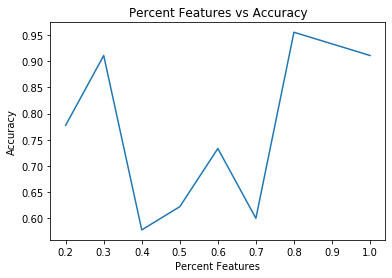

In [9]:
plt.plot(percent_features, acc)
plt.xlabel("Percent Features")
plt.ylabel("Accuracy")
plt.title("Percent Features vs Accuracy")
plt.show()